# Convolutional Networks

In [1]:
# Setup
import tensorflow as tf
import keras

import time as timer
import datetime

import os
import numpy as np
import matplotlib.pyplot as plt

import dataset

### Constants

In [2]:
EPOCH = 20
BATCH = 64

DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODELDIR = "/Users/mghifary/Work/Code/AI/models"

modelpath = os.path.join(MODELDIR, "fashion_mnist-lenet-classifier.h5")

In [3]:
# Load dataset
# data_path = os.path.join(DATADIR, "train-labels-idx1-ubyte.gz")
(x_train, y_train), (x_test, y_test) = dataset.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

(n_train, dx1, dx2) = x_train.shape
n_test = x_test.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle and batch
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH)
dataset_test = dataset_test.batch(BATCH)

In [8]:
n_samples = 30
np.sqrt(n_samples)
np.ceil(np.sqrt(n_samples))

6.0

In [13]:
def visualize_dataset(dataset, title="Untitled", n_samples=9):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)

    # decide subplot dimension
    d = np.sqrt(n_samples)
    d = np.ceil(d).astype("uint8")

    for i, samples in enumerate(iter(dataset.take(n_samples))):
        images = samples[0]
        plt.subplot(d, d, i + 1)
        img = images[0].numpy()
        vmin = np.min(img)
        vmax = np.max(img)
        plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
        plt.axis("off")
    plt.show()

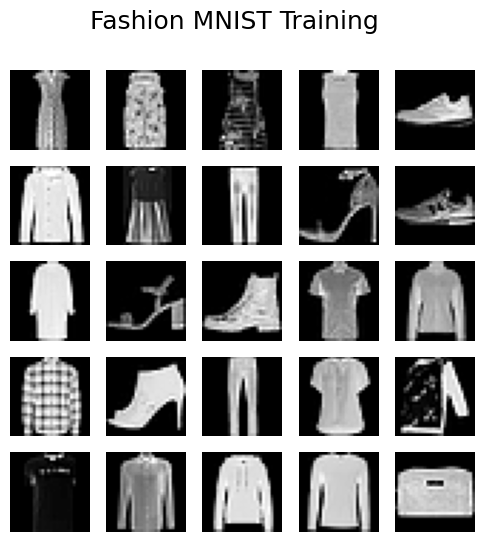

In [16]:
# Visualize training samples
visualize_dataset(dataset, title="Fashion MNIST Training", n_samples=25)

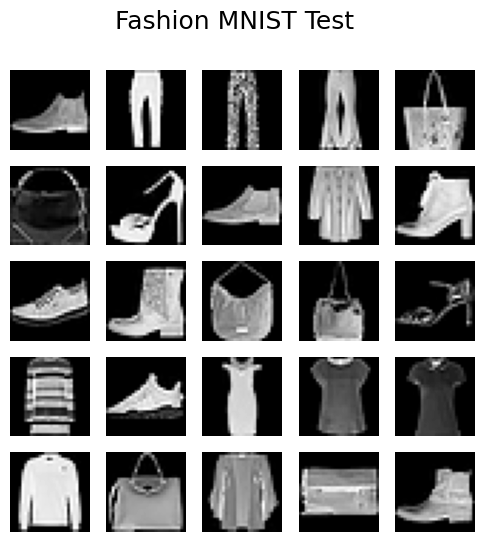

In [17]:
# Visualize test samples
visualize_dataset(dataset_test, title="Fashion MNIST Test", n_samples=25)

In [ ]:
# Build model
class LeNet5(keras.Sequential):
    """LeNet5 architecture"""

    def __init__(self, num_classes=10):
        super().__init__()
        self.add(keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", activation="relu", input_shape=(dx1, dx2, 1)))
        self.add(keras.layers.MaxPool2D((2, 2)))
        self.add(keras.layers.Conv2D(48, kernel_size=(5, 5), padding="valid", activation="relu"))
        self.add(keras.layers.MaxPool2D((2, 2)))
        self.add(keras.layers.Flatten())
        self.add(keras.layers.Dense(256, activation="relu"))
        self.add(keras.layers.Dense(84, activation="relu"))
        self.add(keras.layers.Dense(num_classes))

model = LeNet5(num_classes=10)
model.build(input_shape=(None, dx1, dx2))
model.summary()

Train model

In [ ]:
# Loss and optimizer
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.legacy.Adam(learning_rate=3e-4)


In [ ]:
# Define metrics
train_loss = keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = keras.metrics.SparseCategoricalAccuracy('train_accuracy')

test_loss = keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [ ]:
# Training and test function
@tf.function
def train_on_batch(model, loss_fn, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value = loss_fn(y, y_pred)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_loss(loss_value)
    train_accuracy(y, y_pred)

@tf.function
def test_on_batch(model, loss_fn, x, y):
    y_pred = model(x, training=False)
    loss_value = loss_fn(y, y_pred)
    
    test_loss(loss_value)
    test_accuracy(y, y_pred)

In [ ]:
# Setup summary writers
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/convnet-fashionmnist/' + current_time + '/train'
test_log_dir = 'logs/convnet-fashionmnist/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
# Do training
for epoch in range(EPOCH):
    # Mini-batch training
    train_duration = 0.0
    for step, (x, y) in enumerate(dataset):
        start_t = timer.time()
        train_on_batch(model, loss_fn, optimizer, x, y)
        elapsed_t = timer.time() - start_t

        train_duration += elapsed_t
    
    # Store log
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    # Test
    test_duration = 0.0
    for step, (xt, yt) in enumerate(dataset_test):
        start_t = timer.time()
        test_on_batch(model, loss_fn, xt, yt)
        elapsed_t = timer.time() - start_t

        test_duration += elapsed_t

    # Store log
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

    print(f"Epoch {epoch+1} - Training [loss: {train_loss.result():.5f}, accuracy: {train_accuracy.result():.3f}] ({train_duration:.3f} secs), Test [loss: {test_loss.result():.5f}. accuracy: {test_accuracy.result():.3f}] ({test_duration:.3f} secs)")

    # Save model
    model.save_weights(modelpath, overwrite=True, save_format=None, options=None)

# end of epoch